# Homework 7 Template

Rixin Li & G . Besla

Collaborated with Jimmy Lilly, Madison Walder, Mackenzie James, and Ryan Webster

In [212]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

from ReadFile import Read

# **** import CenterOfMass to determine the COM pos/vel of M33

from CenterOfMassVolDec import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component

from GalaxyMass import ComponentMass


# M33AnalyticOrbit

In [157]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename): # **** add inputs
        """ inputs:
                filename: name of output file"""

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name
        
        self.file=filename
        
        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33 
        
        M33=CenterOfMass('M33_000.txt',2)
        delta33=0.1
        voldec33=4

        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        
        M33P = M33.COM_P(delta33, voldec33)
        
        #M33Pvec=np.sqrt(M33P[0]**2 + M33P[1]**2 + M33P[2]**2)
        
        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        
        M33V = M33.COM_V(M33P[0],M33P[1],M33P[2])
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        M31=CenterOfMass('M31_000.txt',2)
        delta31=0.1
        voldec31=2

        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        
        M31P = M31.COM_P(delta31, voldec31)

        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        
        M31V = M31.COM_V(M31P[0],M31P[1],M31P[2])
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them equal the
        # relative position and velocity VECTORS of M33
        M33_M31PDiff = np.subtract(M33P,M31P).value
        M33_M31VDiff = np.subtract(M33V,M31V).value
        
        self.r0=M33_M31PDiff
        self.v0=M33_M31VDiff
        
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk = scale length (no units)
        
        self.rdisk = 5 

        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        
        self.Mdisk = ComponentMass('M31_000.txt',2).value*1e12
        
        ### bulge
        # **** self.rbulge = set scale length (no units)
        
        self.rbulge = 1

        # **** self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        
        self.Mbugle = ComponentMass('M31_000.txt',3).value*1e12
        
        # Halo
        # **** self.rhalo = set scale length from HW5 (no units)
        
        self.rhalo = 60 #From MASSPROFILE HW

        # **** self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        
        self.Mhalo = ComponentMass('M31_000.txt',1).value*1e12
     
    
    
    def HernquistAccel(self, M, r_a, rvec): # it is easiest if you take as an input the position VECTOR 
        """ Inputs:
                M= Mass of bulge or halo M_Sun
                r_a= scale length
                rvec= vector
            returns:
                accleration vector from a hernquist potential"""
        
        ### **** Store the magnitude of the position vector
        rmag = np.sqrt(rvec[0]**2+rvec[1]**2+rvec[2]**2)
        
        ### *** Store the Acceleration
        #follow the formula in the HW instructions
        Hern =  -self.G*M/(rmag*(r_a+rmag)**2) * rvec
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return Hern
    
    
    
    def MiyamotoNagaiAccel(self, M,rd,rvec):# it is easiest if you take as an input a position VECTOR  r 
        """ Inputs:
               M= Mass of disk for M31 in Msun
               rvec= vector of position of M31
               rd= is self.rdisk
           Returns:
               accleration vector for the miyamoto... potential"""

        zd=self.rdisk/5.0
        ### Acceleration **** follow the formula in the HW instructions
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        #  multiply the whle thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction
        B=rd + np.sqrt(rvec[2]**2+zd**2)
        R=np.sqrt(rvec[0]**2+rvec[1]**2)
        
        ZStuff= B/(np.sqrt(rvec[2]**2+zd**2))
        
        Miya= -self.G*M/(R**2+B**2)**1.5 * rvec * np.array([1,1,ZStuff])
        
        
       
        return Miya
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self, r): # input should include the position vector, r
        """Inputs:
                r= position vector
            returns:
                Total accleraton vector"""

        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 
        abulge= self.HernquistAccel(self.Mbugle, self.rbulge, r)
        ahalo= self.HernquistAccel(self.Mhalo, self.rhalo, r)
        adisk= self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)
        
        acc1= np.add(abulge, ahalo)
        acctot= np.add(acc1, adisk)
        
            
            # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        return acctot
    
    
    
    def LeapFrog(self, dt, r, v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """ Inputs:
                dt= change in time
                r= postition vector
                v= velocity vector
        Returns:
                Rnew= new position vector after certain time dt
                vnew= new velocity vector after certain time dt"""
        # predict the position at the next half timestep
        rhalf = r + v*dt/2
        
        # compute the velocity at the next timestep
        vnew = v + self.M31Accel(r)*dt
        
        # compute the position at the next timestep
        rnew = rhalf + vnew*dt/2
        
        return rnew, vnew# **** return the new position and velcoity vectors
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """ Inputs
                t0= starting time
                dt= time incriments 
                tmax= end simulation time"""

        # initialize the time to the input starting time
        t = t0
        
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((int(tmax/dt)+2, 7))
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t<tmax):  # as long as t has not exceeded the maximal time 
            
            # **** advance the time by one timestep, dt
            t+=dt
           
            # **** store the new time in the first element of the ith row
            orbit[i][0] = t
            
            # ***** advance the position and velocity using the LeapFrog scheme
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
            
            posnew, velnew = self.LeapFrog(dt, orbit[i-1][1:4],orbit[i-1][4:7])
            
         
    
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
            # A[n, 5:8] 
            # where the syntax is row n, start at column 5 and end BEFORE column 8
            
            orbit[i][1:4]= posnew
            
            
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i][4:7]= velnew
            
            
            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i+=1
        
        
        
        # write the data to a file
        np.savetxt(self.file, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function
        

In [158]:
#create a output file and call class
M33Orbit=M33AnalyticOrbit('Enemy.txt')

In [189]:
#perferm integration with start, end, and time incriments in GYR
M33Orbit.OrbitIntegration(0,0.01,10)

In [190]:
#put data into array
data=np.genfromtxt('Enemy.txt',dtype=None, names=True)

In [191]:
#compute sep, vel, and get time from data array 
r=np.sqrt(data['x']**2+data['y']**2+data['z']**2)
vel=np.sqrt(data['vx']**2+data['vy']**2+data['vz']**2)
t=data['t']


In [214]:
#use vector diff from OrbitCOM HW to get the sim sep and vel
def vectordiff(data1,data2):
    #inputs:
    #   Data1 is first set of data (MW or M33)
    #   data2 is second set of data (M31)
    #retruns:
    #   mag of relative separation and velocity
    
    #initialize the vectors
    Rp=np.zeros(len(data1))
    Rv=np.zeros(len(data1))
    Time=np.zeros(len(dataM31sim))
    
    #data colomns t=0,x=1,y=2,z=3,vx=4,vy=5,vz=6
    #need for loop because for every ith snapshot you need to subtract each x,y,z,etc comp and store it as ith R value
    for i in range(len(data1)):
        
        x=data1[i][1]-data2[i][1] #x1-x2= xcomp of relative position vector (vector subtraction)
        y=data1[i][2]-data2[i][2]
        z=data1[i][3]-data2[i][3]
        Rp[i]=np.sqrt(x**2+y**2+z**2) #calc mag of relative position

        vx=data1[i][4]-data2[i][4] #similar for velcocity
        vy=data1[i][5]-data2[i][5]
        vz=data1[i][6]-data2[i][6]
        Rv[i]=np.sqrt(vx**2+vy**2+vz**2) #calc mag of relative velocity
        
        #need time for Plot
        Time[i]=dataM31sim[i][0]
    
    return Rp,Rv,Time

In [215]:
#put sim data into arrays
dataM31sim=np.genfromtxt('Orbit_M31.txt',dtype=None, names=True)
dataM33sim=np.genfromtxt('Orbit_M33.txt',dtype=None, names=True)

In [216]:
#compute sep and vel of sim data
M33_M31Sep, M33_M31Vel, Time = vectordiff(dataM31sim, dataM33sim)

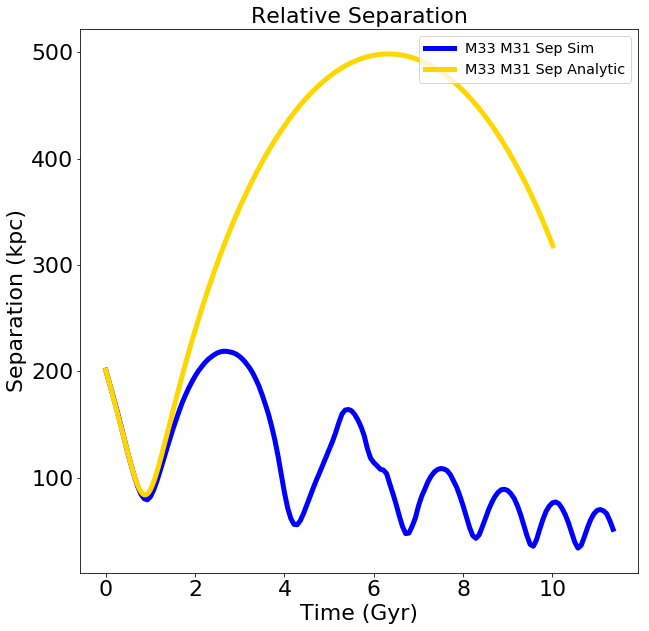

In [224]:
#plot both sim and analytic sep 

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the Separation vs Time 
ax.plot(Time,M33_M31Sep,color='blue', linewidth=5, label='M33 M31 Sep Sim')
ax.plot(t,r, color='gold', linewidth=5, label='M33 M31 Sep Analytic')

# Add labels
plt.xlabel(r'Time (Gyr)', fontsize=22)
plt.ylabel(r'Separation (kpc)', fontsize=22)
plt.title(r'Relative Separation',fontsize=22)

#x limit
#plt.xlim(6.0, 7.5)   

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')



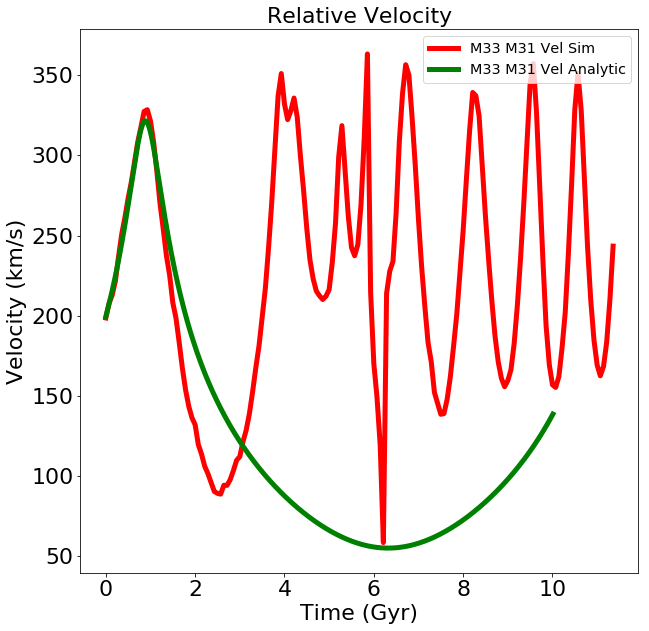

In [225]:
#plot both sim and analytic vel 

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the velocity vs time
ax.plot(Time,M33_M31Vel,color='red', linewidth=5, linestyle='-', label='M33 M31 Vel Sim')
ax.plot(t,vel, color='green', linewidth=5, label='M33 M31 Vel Analytic')

# Add labels
plt.xlabel(r'Time (Gyr)', fontsize=22)
plt.ylabel(r'Velocity (km/s)', fontsize=22)
plt.title(r'Relative Velocity',fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

# Questions

Question 1:

The plots are relativly the same for roughly 1 Gyr and then diverge greatly. In the separation simulation data, M33 begins to "bounce" while in the anayltic continues to arch and come back slowly making a much longer orbit. Similar for the velocity dispertion, the simulation starts to change in velocity a lot sooner than the analytic data. 

Question 2:

We are missing the MW! The MW will exhibit a force on M33 and M31 which will change the orbit of M33 and its velocity dispertion with M31. This force will only get stronger as MW and M31 collide in roughly 6 Gyr.

Question 3:

With the milky way, this becomes a three body problem. A possible way to implement the MW is to make M31 and M33 a combined body since M31 is about ten times bigger than M33. We could get their combined COM and use that for the integration and see if that looks more like the simulation data. 